# Statistical Analysis

## Import Dependencies

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### Correlation Matrix
We will try and investigate how each feature are correlated with one another through a correlation matrix.

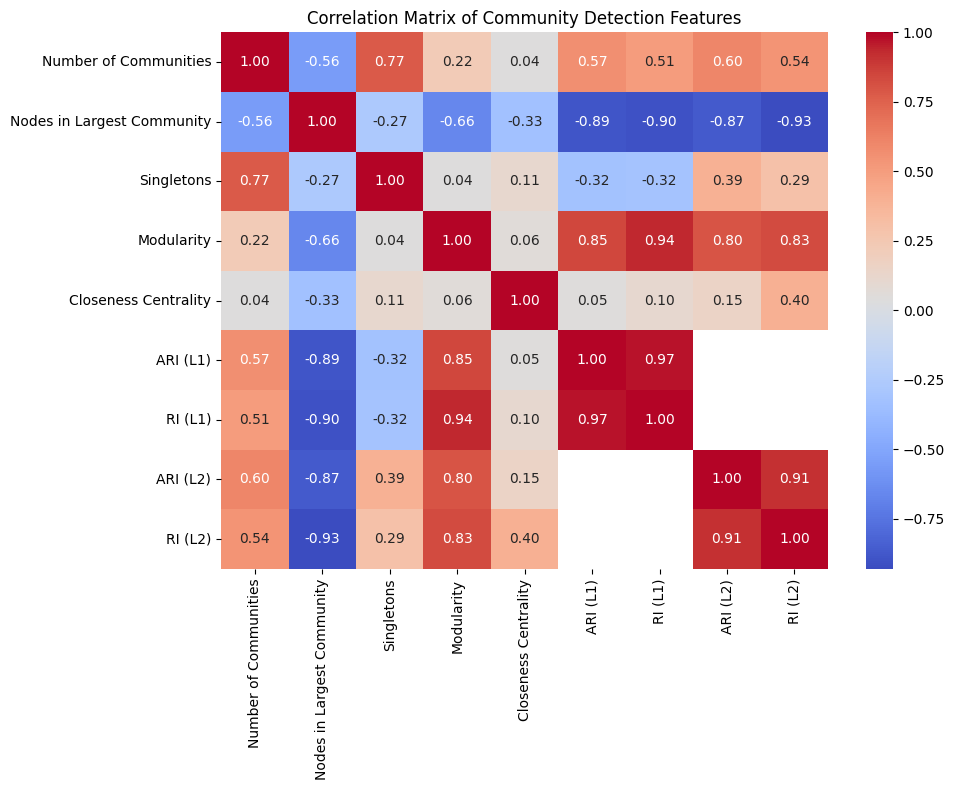

In [10]:
df_15 = pd.read_csv("../../results/cho-384/community_detection_results_by_delta/cho-384_cd_results_delta_0.15.csv")
df_50 = pd.read_csv("../../results/cho-384/community_detection_results_by_delta/cho-384_cd_results_delta_0.50.csv")
df_85 = pd.read_csv("../../results/cho-384/community_detection_results_by_delta/cho-384_cd_results_delta_0.85.csv")

combined_df = pd.concat([df_15, df_50, df_85], ignore_index=True)
numeric_cols = [
    "Number of Communities", "Nodes in Largest Community", "Singletons", 
    "Modularity", "Closeness Centrality", "ARI (L1)", "RI (L1)", 
    "ARI (L2)", "RI (L2)"
]
numeric_df = combined_df[numeric_cols]
correlation_matrix = numeric_df.corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Community Detection Features")
plt.tight_layout()
plt.show()

# Display correlation values sorted by correlation with ARI (L1) and ARI (L2)
ari1_corr = correlation_matrix["ARI (L1)"].sort_values(ascending=False)
ari2_corr = correlation_matrix["ARI (L2)"].sort_values(ascending=False)

### Linear Regression Analysis: Predicting ARI (L1)

We fit a simple linear regression model to understand which structural properties of the community detection output are most predictive of **Adjusted Rand Index at Level 1 (ARI L1)**. The features used were:

- **Number of Communities**
- **Nodes in Largest Community**
- **Singletons**
- **Modularity**
- **Closeness Centrality**

In [15]:
# Prepare dataset: drop rows with NaNs and separate X and y
features = ["Number of Communities", "Nodes in Largest Community", "Singletons", 
            "Modularity", "Closeness Centrality"]
target = "ARI (L1)"

df_clean = combined_df[features + [target]].dropna()

X = df_clean[features]
y = df_clean[target]

# Split into training and test sets for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a simple linear regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Collect coefficients with feature names
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": reg.coef_
}).sort_values(by="Coefficient", ascending=False)

print("R-squared: ", r2)
coef_df

R-squared:  0.8533518090860199


,Feature,Coefficient
3,Modularity,0.508998
0,Number of Communities,0.004632
4,Closeness Centrality,0.001066
1,Nodes in Largest Community,-0.000750
2,Singletons,-0.069671


#### Model Performance
- **R² = 0.853**
  - This means that **85.3% of the variance in ARI (L1)** is explained by the selected features — a strong indication of a well-fitting linear model.

#### Feature Coefficients

| Feature                   | Coefficient | Interpretation |
|---------------------------|-------------|----------------|
| **Modularity**            | +0.509      | Strong positive predictor. High modularity leads to high ARI. |
| **Number of Communities** | +0.0046     | Weak positive effect. Slight benefit from more partitions. |
| **Closeness Centrality**  | +0.0011     | Negligible influence on ARI. |
| **Nodes in Largest Community** | -0.00075 | Weak negative effect. Large dominant clusters may reduce ARI. |
| **Singletons**            | -0.0697     | Moderate negative impact. More singletons generally lead to worse ARI. |

#### Implications
- **Modularity** is the strongest and most consistent predictor of ARI performance at Level 1, reinforcing its value as a proxy for meaningful community structure.
- A **high number of singletons** and **oversized dominant communities** appear to **dilute the alignment** with biological classification.
- Closeness centrality, surprisingly, offers little predictive value here — suggesting that **global integration isn't as relevant** to ARI as modular structure is.

### Linear Regression Analysis: Predicting ARI (L2)

In [14]:
features = ["Number of Communities", "Nodes in Largest Community", "Singletons", 
            "Modularity", "Closeness Centrality"]
target = "ARI (L2)"

df_clean_l2 = combined_df[features + [target]].dropna()

X_l2 = df_clean_l2[features]
y_l2 = df_clean_l2[target]

# Train-test split
X_train_l2, X_test_l2, y_train_l2, y_test_l2 = train_test_split(X_l2, y_l2, test_size=0.2, random_state=42)

# Fit linear regression model
reg_l2 = LinearRegression()
reg_l2.fit(X_train_l2, y_train_l2)

# Predict and evaluate
y_pred_l2 = reg_l2.predict(X_test_l2)
r2_l2 = r2_score(y_test_l2, y_pred_l2)

# Get coefficients
coef_df_l2 = pd.DataFrame({
    "Feature": features,
    "Coefficient": reg_l2.coef_
}).sort_values(by="Coefficient", ascending=False)

print("R-squared: ", r2_l2)
coef_df_l2

R-squared:  0.9617280776795959


,Feature,Coefficient
3,Modularity,0.129825
2,Singletons,0.002282
1,Nodes in Largest Community,-0.000333
0,Number of Communities,-0.000742
4,Closeness Centrality,-0.067421


#### 🧪 Model Performance
- **R² = 0.962**
  - This means **96.2% of the variance in ARI (L2)** is explained by our model — a near-perfect fit, suggesting strong structural indicators.

#### Feature Coefficients

| Feature                   | Coefficient | Interpretation |
|---------------------------|-------------|----------------|
| **Modularity**            | +0.130      | Strong positive predictor. High modularity leads to high ARI. |
| **Singletons**            | +0.0023     | Slight positive effect — may reflect helpful fragmentation at finer resolution. |
| **Nodes in Largest Community** | -0.00033 | Weak negative effect — oversized dominant clusters harm ARI. |
| **Number of Communities** | -0.00074    | Slightly negative — overfragmentation may lower biological alignment. |
| **Closeness Centrality**  | -0.067      | Moderate negative effect — indicates overly centralized networks hurt interpretability. |

#### Implications
- Like in Level 1, **modularity** is the strongest driver of good alignment with biological labels.
- The **negative effect of closeness centrality** suggests that highly integrated or tight networks may not correspond well with true biological classes at fine-grained levels.
- Slightly positive singleton impact may reflect **sharpened resolution**, especially if weakly connected genes are excluded from noisy communities.